# Vapor Python Overview *(Currently an outline)*

TODO: Intro

## Setup

To begin, we will import the vapor modules we will be using.

In [38]:
from vapor import session, renderer, dataset, camera, utils
from vapor.animation import Animation
from vapor.dataset import Dataset
from vapor.renderer import Renderer

### Session Files

Vapor's Python API is built around [sessions](https://ncar.github.io/VaporDocumentationWebsite/pythonAPIReference/userModules/vapor.session.html) and session files. A session contains all the information required to recreate a visualization, such as dataset information, rendering settings, and camera position. In this notebook we'll create a new visualization that will be stored within our session. We can then save it as a session file, which can be opened in Vapor's GUI application or in another Python script.


In [39]:
ses = session.Session() # Create new session

### Importing Data

Once we've created our session, we'll want to load our dataset. Vapor supports a number of spatial data formats, which can be viewed with `Dataset.GetDatasetTypes()`

In [40]:
Dataset.GetDatasetTypes()

['vdc', 'wrf', 'cf', 'mpas', 'bov', 'ugrid']

We will be using data from the WRF model of hurricane Katrina from 2005. The data can be downloaded from [here](https://drive.google.com/file/d/1OjBhTFZEwn-JI2FNaSlkiriV43Tcf186/view). We can load the dataset into our session using `ses.OpenDataset()` and passing two parameters. The first specifies the file format, in this case `dataset.WRF`. The second is a list of file paths. Since we only have one file, we list just the one. But, for example, if our dataset had different time steps spread across multiple files, we could list all the file paths here.

In [41]:
data = ses.OpenDataset(dataset.WRF, ["wrfout_d02_2005-08-29_02"])

The dataset contains a number of atmospheric variables that describe attributes of the storm, such as pressure, winds, clouds, and rain. For this example, we will use two variables: `LANDMASK`, a 2 dimensional variable to display the coastlines, and `QCLOUD`, a 3 dimensional variable to visualize the cloud formation of the storm.

In [42]:
print("Data Variables:")
vars = ["LANDMASK", "QCLOUD"]
for var in data.GetDataVarNames():
    if var in vars:
        print(f" {var}")
        print(f"    Time Varying: False")
        print(f"    Dimensionality:", data.GetVarGeometryDim(var))
        print(f"    Coordinates:", data.GetVarCoordVars(var, True))
        print("     Data Range:", data.GetDataRange(var))

Data Variables:
 LANDMASK
    Time Varying: False
    Dimensionality: 2
    Coordinates: ['XLONGX', 'XLATY']
     Data Range: [0.0, 1.0]
 QCLOUD
    Time Varying: False
    Dimensionality: 3
    Coordinates: ['XLONGX', 'XLATY', 'Elevation']
     Data Range: [-8.626847608668442e-13, 0.002441433956846595]


## Apply Renderers

Now that we've loaded our data, it's time to start the visualization process. Visualization in Vapor is based around renderers, which display data with customizable colors and opacities. The [application reference](https://ncar.github.io/VaporDocumentationWebsite/vaporApplicationReference/renderers.html) contains details for each of the renderers, and each one functions similarly in Python.

### 2D Data Renderer
The 2D Data Renderer displays a 2D data variable along the plane described by the dataset. We will use it to display our `LANDMASK` variable, which will shade the surface with land or water. First we select the renderer type by calling `NewRenderer()` on the dataset. Then we select which variable we want to visualize by calling `SetVariableName()` on the renderer.

In [43]:
land = data.NewRenderer(renderer.TwoDDataRenderer)
land.SetVariableName("LANDMASK")

We can adjust the appearance of our renderer by modifying its transfer function. [Transfer functions](https://ncar.github.io/VaporDocumentationWebsite/vaporApplicationReference/basicRendererControls.html#appearancetab) describe the color and opacity of the data in the visualization. The `delta` colormap is built into vapor and can be applied to our transfer function to shade the land green and the water blue. The [transfer function notebook](https://projectpythia.org/vapor-python-cookbook/notebooks/transfer_function_example.html) provides more examples on how to customize a transfer function.

In [44]:
land_tf = land.GetTransferFunction("LANDMASK")
land_tf.LoadBuiltinColormap("Diverging/delta")

0

Now, we can call `ses.Show()` to display our visualization!

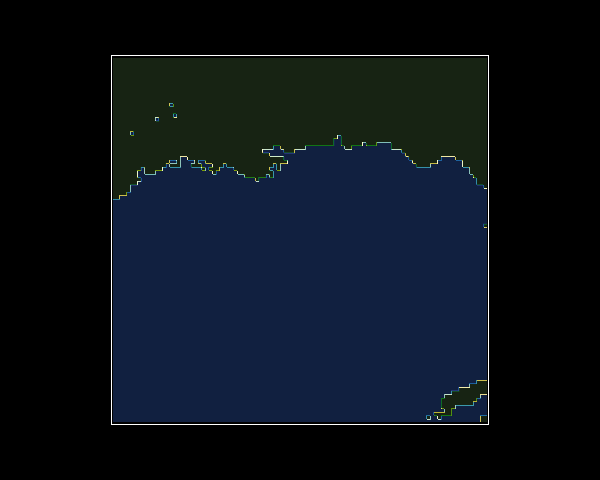

In [45]:
ses.Show()

### Volume Renderer

Next, let's create a visualization for a three dimensional variable. The `QCLOUD` variable measures the cloud thickness (?) at every gridpoint. We can use a volume renderer to display where the clouds are thickest. As before, we first select our renderer and variable name.

In [46]:
clouds = data.NewRenderer(renderer.VolumeRenderer)
clouds.SetVariableName("QCLOUD")

We can customize renderer as desired. First we will set the colors to be on a white-gray-black scale. Then we will edit the opacities of the renderer. We want areas with almost no clouds to be completely transparent, while areas with more clouds to be more obaque.

In [47]:
clouds_tf = clouds.GetTransferFunction("QCLOUD")
clouds_tf.LoadBuiltinColormap("Sequential/BlackWhite")
new_colors = [(r, g, b) for r, g, b, _ in list(reversed(clouds_tf.GetMatPlotLibColormap().colors))] # Access and reverse RGB list from current color map
clouds_tf.SetColorRGBList(new_colors) # Assign new RGB colors to transfer function
clouds_tf.SetOpacityControlPoints([[0,0],[0.00001,0.01], [0.0001, 0.1], [0.0010,0.9]]) # Change opacities

We want to set our camera at an angle so that we can see the 3D structure of the clouds. The [camera module](https://ncar.github.io/VaporDocumentationWebsite/pythonAPIReference/userModules/vapor.camera.html) provides several functions to control the camera position and angle. The most robust is the `LookAt()` function, which takes two lists of length three. The first describes the camera's position, and the second describes the camera's target.

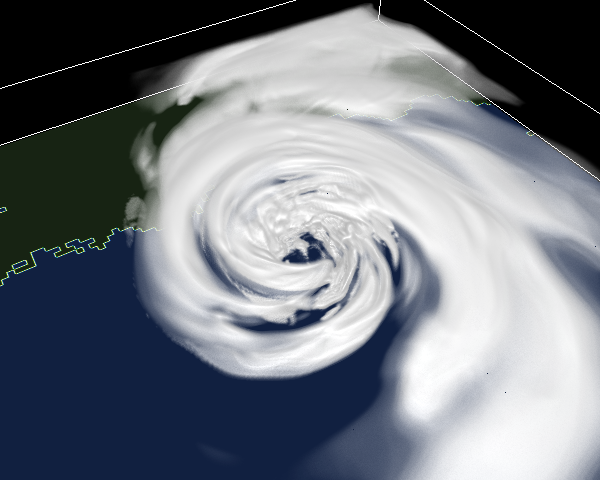

In [48]:
ses.GetCamera().LookAt([-420811.28125 * 1.8, 2737271.75 * 0.8, 1904108.375 * 0.4], [-420811.28125, 2737271.75, 10466.52343731 * 1.5])
ses.Show()

Finally, we can create an animation to rotate the camera. We keep the target fixed while rotating our camera.

Camera angles are currently very adhock. Find better way?

In [49]:
anim = Animation(ses)
ses.GetCamera().LookAt([-420811.28125 * 1.8, 2737271.75 * 0.8, 1904108.375 * 0.4], [-420811.28125, 2737271.75, 10466.52343731 * 1.5])
nframes = 100
for i in range(0, nframes, 1):
    ses.GetCamera().LookAt([(-420811.28125 * 1.8) + (5000 * i), 2737271.75 * 0.8, (1904108.375 * 0.4) - (50000 * 0)], [-420811.28125, 2737271.75, 10466.52343731 * 1.5])
    anim.CaptureFrame()
    print(f"Rendering Animation [{'#'*round(i*40/nframes)}{' '*round(40-(i*40/nframes))}] {(i+1)*100/nframes:.0f}%", end="\r")

In [50]:
anim.Show()

## Add Annotations

We can finalize our visualization with some [annotations](https://ncar.github.io/VaporDocumentationWebsite/pythonAPIReference/userModules/vapor.annotations.html). For a more in depth tutorial on annotations, visit our [annotation cookbook](https://projectpythia.org/vapor-python-cookbook/notebooks/annotation_example.html).

TODO: differentiate from other notebook?

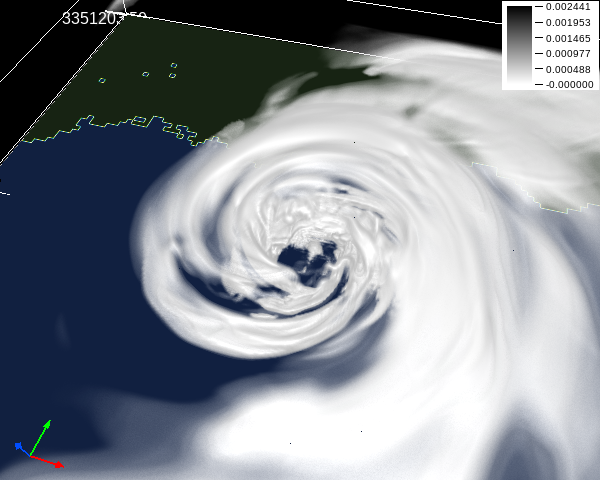

In [51]:
colorbar = clouds.GetColorbarAnnotation()
colorbar.SetEnabled(True)
colorbar.SetCornerPosition((1,1))

axis = ses.GetAxisAnnotations()
axis.SetAxisAnnotationEnabled(True)

scene = ses.GetSceneAnnotations()
scene.SetAxisArrowEnabled(True)

ses.Show()

## Export

Now that we've created our visualization, we'll want to save and export it. We can save visualization as a png, jpg, or tif using `ses.Render()`

In [52]:
ses.Render("Katrina.tif")

0

We can also use `ses.Save()` to save our session to a file. We can load this file in a different python script or in the Vapor GUI.

In [53]:
ses.Save("Katrina.vs3")

0

To access this session in a different Python script, we can use a line like this:

In [54]:
ses = session.Session()
ses.Load("Katrina.vs3")

Dataset: 'wrfout_d02_2005-08-29_02'


0